## Imports

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier

from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report




In [207]:


data = pd.read_csv('preprocessed_data.csv')
data_no_encoding = pd.read_csv('preprocessed_data_no_categorical_encoding.csv')

y = data['Attrition']

X = data.drop('Attrition', axis = 1 )
X_no_encoding = data_no_encoding.drop('Attrition', axis = 1)

X_train , X_test, y_train, y_test = train_test_split(X, y , train_size= 0.75, random_state=42, stratify = y)
#we make sure to do a stratified sampling because of the imbalanced dataset
#Stratification does NOT fix imbalance, it only preserves it.
X_no_encoding_train = X_no_encoding.loc[X_train.index]
X_no_encoding_test = X_no_encoding.loc[X_test.index]



print(f'the size of the training dataset is {X_train.shape}, and the test one is {X_test.shape}')

print(f'percentage of attrition in Training is {100 * len(y_train[y_train==1])/len(y_train)}% and in test {100 * len(y_test[y_test==1])/len(y_test)}% ')

the size of the training dataset is (1102, 40), and the test one is (368, 40)
percentage of attrition in Training is 16.1524500907441% and in test 16.032608695652176% 


In [208]:
categorical_cols = ['BusinessTravel','Education','EnvironmentSatisfaction','JobInvolvement',
                'JobLevel','JobSatisfaction','PerformanceRating','RelationshipSatisfaction',
                'StockOptionLevel','WorkLifeBalance', 'Department','EducationField','Gender',
                'JobRole','MaritalStatus','OverTime']

set(categorical_cols) <= set(X_no_encoding.columns) # simple verification that the ensemble of ordinal and nominal columns are actually present in the dataframe

True

## Models

We will go through a lot of models of classification, and organize the results in a dataFrame.

For each model we'll try to retrieve as much info as possible.

All models has be evaluated on the same data splits so comparisons are fair.

The nexxt step after splitting data between training and test is to understand how each model behaves.

This will be done by validation on the training data only first


In [209]:
results = pd.DataFrame(columns=['Mean_AUC','Mean_F1','Mean_Precision','Mean_Recall', 'Mean_Accuracy'])

scoring = {
    "auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "accuracy": "accuracy"
}

In [210]:
from sklearn.model_selection import StratifiedKFold

cv  = StratifiedKFold(n_splits = 5 , shuffle= True , random_state= 425)
#shuffle is true so data is shuffled before split and to protect in case data were ordered somehow by classes


In [211]:
def crossValidate(model_name, model, X_train, y_train, cross_info):

    cv_results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=cross_info,
        scoring=scoring,
    )

    aggregated_metrics = [value.mean() for (key, value) in cv_results.items()]
    results.loc[model_name] = aggregated_metrics[2:] # the first two values in the list corresponds to fit_time and score_time

"""
In logistic regression :
    C = 1/λ (where λ is the regularization strength)
    Inverse relationship: Smaller C means stronger regularization, larger C means weaker regularization
"""

models = {
    'simple_logistic_regression' : LogisticRegression(C= np.inf, max_iter=1000, random_state=42),
    'logistic_regression_lasso' : LogisticRegression(l1_ratio= 1 ,solver = 'liblinear', C = 1 , max_iter=1000, random_state=42), #the default solver lbfgs doesn't support l1 penalty
    'logistic_regression_ridge' : LogisticRegression(l1_ratio= 0 , C = 1, max_iter=1000, random_state=42),
    'logistic_elastic_net' :  LogisticRegression(l1_ratio=0.5, solver = 'saga', C=1,  max_iter= 1000, random_state=42), # only saga supports elasticnet
    'K nearest neighbors' : KNeighborsClassifier(n_neighbors=7, weights ='distance'), #weights to distance to closer neighbors has more important vote than further ones
    'SVM_gaussian_kernel' : SVC(kernel ='rbf', random_state=42),
    'SVM_polynomial_kernel' : SVC(kernel='poly',random_state=42),
    'SVM_linear_kernel' : SVC(kernel='linear',random_state=42),
    'Decion_tree_gini' : DecisionTreeClassifier(criterion='gini', random_state=17), #gini impurity as criterion of purity in each node
    'Decision_tree_entropy' :  DecisionTreeClassifier(criterion='entropy', random_state=17), #normally we shouldn't expect much difference but both of them are very instable anyway
    'Random Forest' : RandomForestClassifier(random_state = 690),
    'GradientBoosting' : GradientBoostingClassifier(loss = 'log_loss', n_estimators= 150, max_depth = 5),
    'XGBoost' : XGBRFClassifier(),
    'lightGBM' : LGBMClassifier(),
        }

# TODO I would have loved to use catboost as well because it can deal with datasets like plug and play
# catboost can use categorical features without encoding , trees use subset of modalities when splitting
# but unfortunatly there a version conflict causing the dollowing error : 'CatBoostClassifier' object has no attribute '__sklearn_tags__'

In [212]:

for model_name , model in models.items() :
    crossValidate(model_name, 
                  model, 
                  X_train, 
                  y_train, 
                  cv)
    


/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1170: UserWarning: Setting penalty=None will

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 142, number of negative: 739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 881, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161180 -> initscore=-1.649471
[LightGBM] [Info] Start training from score -1.649471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 142, number of negative: 739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [In

The table we can see above resumes the performance of each model via a cross validation of 5 splits

However this was done to give us an idea on the performance of each model and in no case reflects the full abilities of the models that were tested as:

    No HyperParameter tuning or Gridsearch was done to find the optimal parameters 

    Models haven't been tested on the test observations yet 

We'll class the models based on eachmetric and dive deep into the models depending on the metric we care more about 

In [213]:
results

,Mean_AUC,Mean_F1,Mean_Precision,Mean_Recall,Mean_Accuracy
simple_logistic_regression,0.845945,0.597337,0.740985,0.506825,0.890243
logistic_regression_lasso,0.847598,0.584464,0.766090,0.478889,0.891148
logistic_regression_ridge,0.847781,0.584744,0.771537,0.479206,0.892061
logistic_elastic_net,0.847624,0.576249,0.765281,0.467619,0.890239
K nearest neighbors,0.729879,0.242328,0.783636,0.146984,0.856639
SVM_gaussian_kernel,0.849805,0.268713,0.842778,0.163492,0.859362
SVM_polynomial_kernel,0.841771,0.402881,0.891414,0.269841,0.875673
SVM_linear_kernel,0.845566,0.574598,0.722358,0.484762,0.886610
Decion_tree_gini,0.592436,0.316203,0.303828,0.332063,0.768601
Decision_tree_entropy,0.593012,0.310356,0.328807,0.303968,0.788573


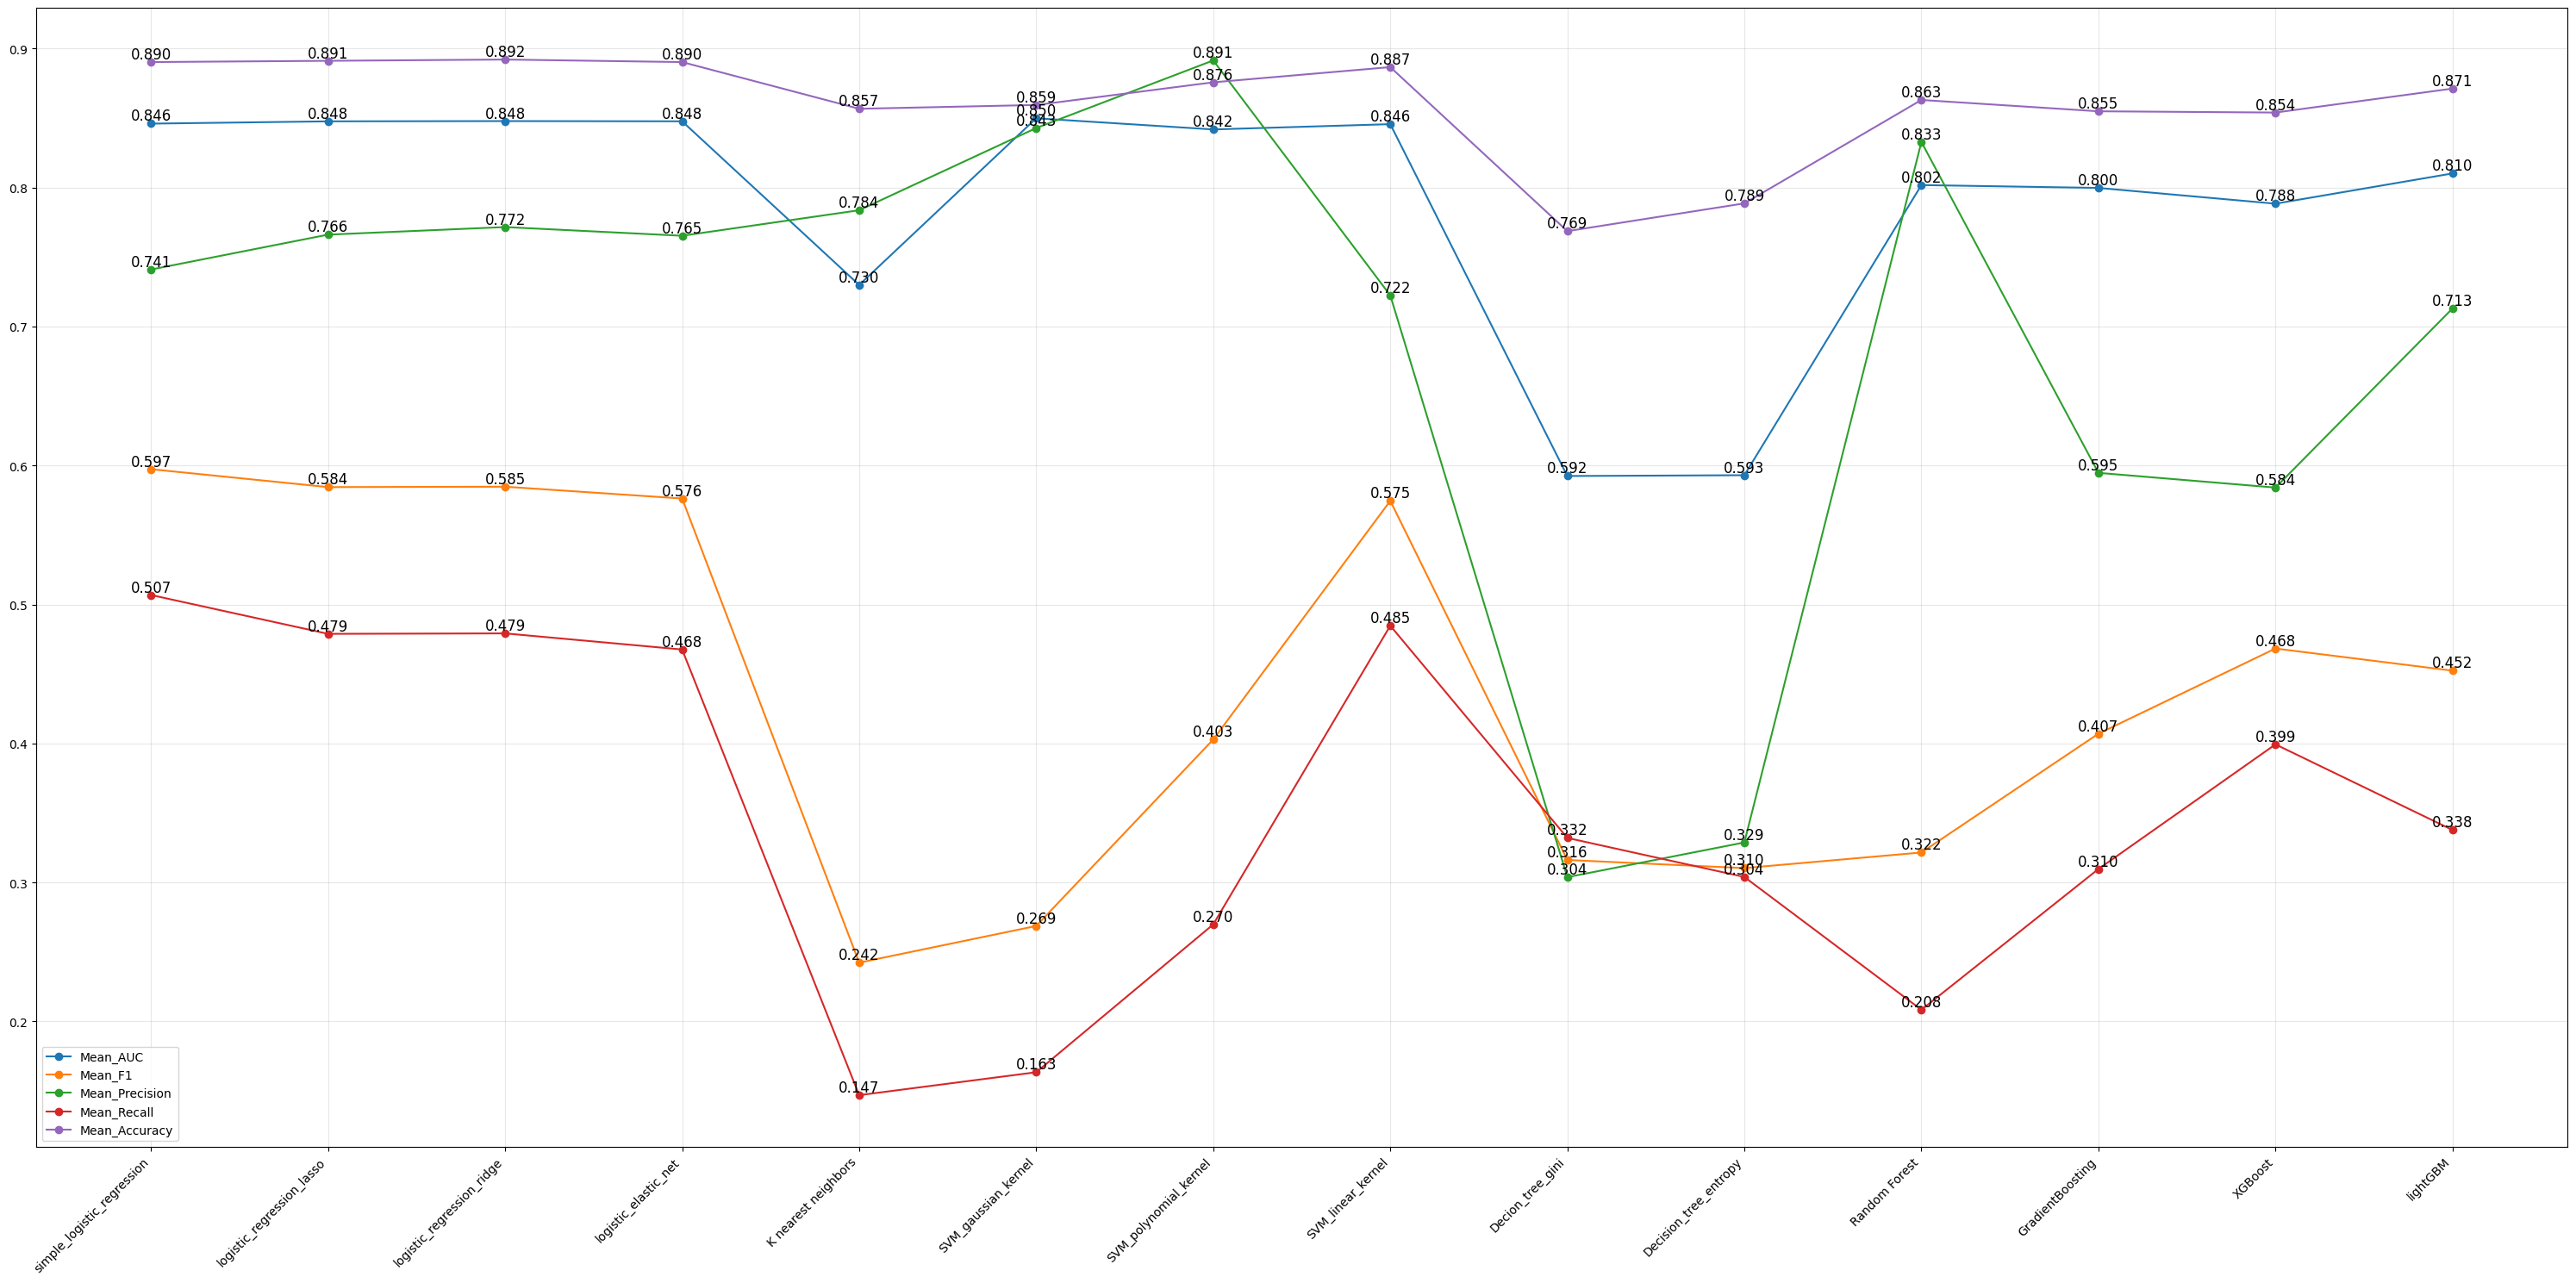

In [214]:
plt.figure(figsize=(30, 15))

models = results.index.tolist()
x = np.arange(len(models))

for col in results.columns:
    y = results[col].values
    plt.plot(x, y, marker='o', label=col)

    # 🔢 annotate values
    for i, val in enumerate(y):
        plt.text(
            i, val,
            f"{val:.3f}",
            fontsize=12,
            ha='center',
            va='bottom'
        )

plt.xticks(x, models, rotation=45, ha="right")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


All the metrics have some information to reflect , so we'll favorise models that excel in all of them  or the majority of them.

However we do care also more about AUC since, as mentionned before , the datset is clearly imbalaced but also about Recall ( among all the the employees that truly left, how much did we correctly predict ).

We do care a lot about recall, because it's really important to captivate all the employees before they churn 

With that being said we'll start with logistic regression , then Random Forest then SVM and last XGBoost

## Logistic Regression

In [215]:
Kfold = StratifiedKFold( n_splits=10, shuffle= True, random_state= 42)
cross_metrics = cross_validate (estimator= LogisticRegression(max_iter=1000),
                X= X_train, y = y_train, cv = Kfold,
                  scoring=['roc_auc','recall'], )

for metric in ['test_roc_auc', 'test_recall']:
    print (f'the average {metric.split('_')[-1]} for 10 splits is {cross_metrics[metric].mean() }')


the average auc for 10 splits is 0.8522529005368705
the average recall for 10 splits is 0.48692810457516333


Before this there is something really dangerous i didn't pay attention to : Data Leakage

    Scaling/log transforms must be learned only from training folds ( we did EDA like Standard scaling of numerical variables using the entire datasets :(( )

    Otherwise CV scores are optimistic

AUC ≈ 0.85 → good separability

Recall ≈ 0.49 → decision threshold issue, not necessarily model weakness

This means:

The model ranks employees well

But the default threshold (0.5) is too conservative

    GridSearch alone will not fully fix recall — threshold tuning will.

    GridSearchCV systematically evaluates multiple combinations of hyperparameters using cross-validation and selects the combination that optimizes a chosen metric.

What it is NOT

     It does not “learn better features” !!!!!!

     It does not fix a bad preprocessing pipeline !!!!!!

     It does not change model assumptions !!!!!!

GridSearch only answers:

“Given this model family and this preprocessing, which configuration generalizes best under my metric?”



Why no pipeline?

For this exploratory phase, I fixed preprocessing to focus on model behavior and hyperparameter effects. 

I’m aware this introduces optimistic bias, so for final validation or deployment I would encapsulate all steps in a pipeline.

In [220]:
# In grid search , here are the parameters that e care to explore, the rest will be kept as default 

parameters_grid = {
    "C": np.logspace(-3, 2, 10), # 10 evenly space values between 1e-3 and 100
    "class_weight": [None, "balanced"],
    "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]  # only used if elasticnet
}

startified_Kfold = StratifiedKFold(n_splits= 10, shuffle= True, random_state= 42)

grid = GridSearchCV(
    estimator = LogisticRegression(max_iter=1000, random_state=42, solver= 'saga', penalty = 'elasticnet', n_jobs=-1), # saga supports all penalties
    param_grid = parameters_grid,
    scoring = 'recall',
    cv = startified_Kfold,
    return_train_score = True # this allow us to unspect overfitting
)


In [221]:
grid

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([1.0000...00000000e+02]), 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [222]:
grid.fit(X_train,y_train)

/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/zakaria/projects/attrition_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([1.0000...00000000e+02]), 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [ ]:
print('the combination of parameters that maximize our metric are ', grid.best_params_)
print('the recall value correspond to this optimization is ', grid.best_score_) #The mean cross-validated score on the TRAINING data, using the metric i chose (recall),averaged over all CV folds,for the best hyperparameter combination.

the combination of parameters that maximize our metric are  {'C': np.float64(0.046415888336127795), 'class_weight': 'balanced', 'l1_ratio': 0.1}
the recall value correspond to this optimization is  0.7637254901960786


In [247]:
# Now let's test our best model on test data 

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test) 
y_prob = best_model.predict_proba(X_test)[:,1]

#measure the performance
print('The best recall is equal to ', recall_score(y_test,y_pred))
print('The best auc is equal to ', roc_auc_score(y_test,y_prob))

print('The confusion matrics looks like\n', confusion_matrix(y_test,y_pred))
print('The classifictaion report looks like \n', classification_report(y_test,y_pred))


The best recall is equal to  0.6949152542372882
The best auc is equal to  0.793538478415885
The confusion matrics looks like
 [[252  57]
 [ 18  41]]
The classifictaion report looks like 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       309
           1       0.42      0.69      0.52        59

    accuracy                           0.80       368
   macro avg       0.68      0.76      0.70       368
weighted avg       0.85      0.80      0.81       368

